Done.


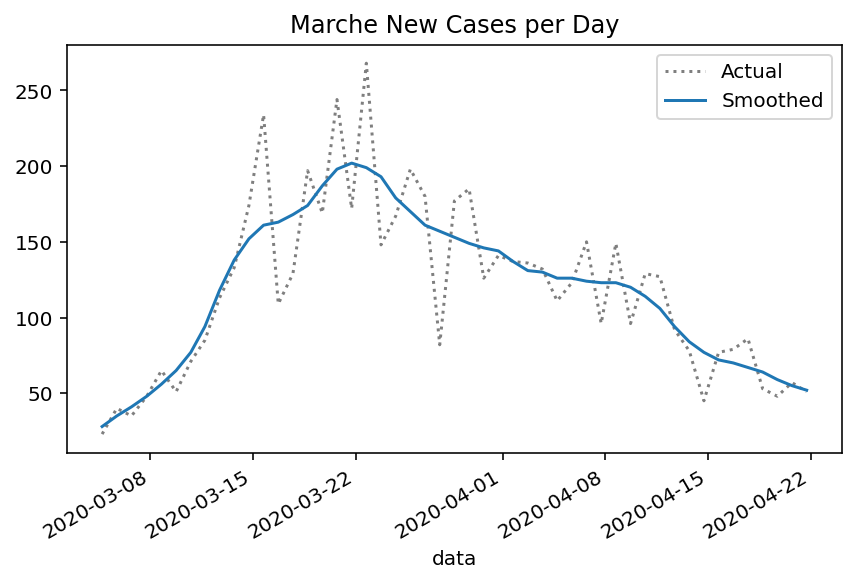

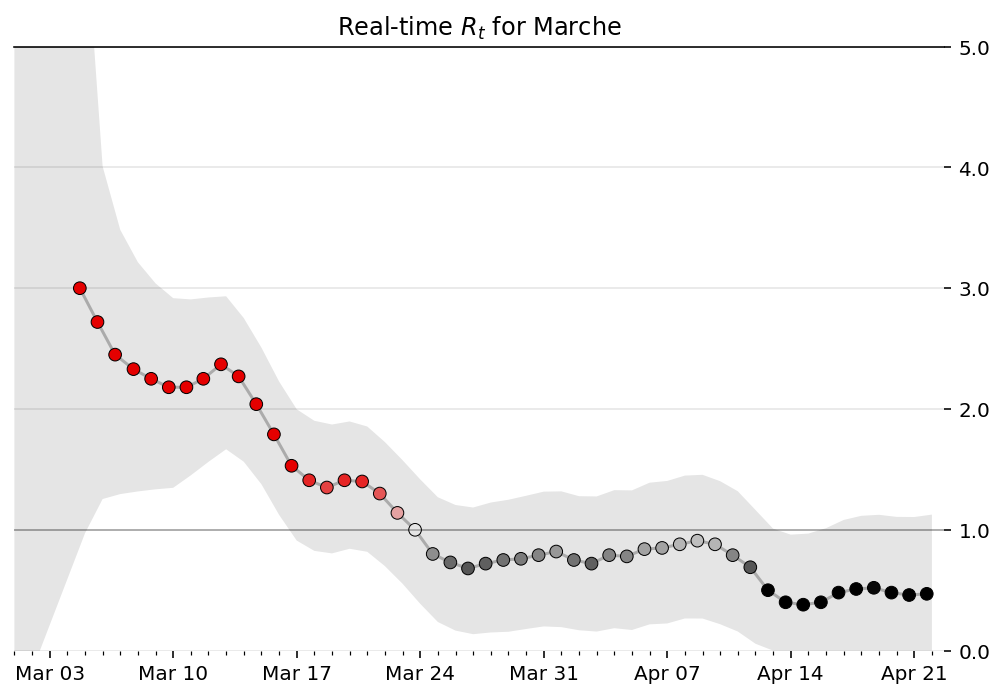

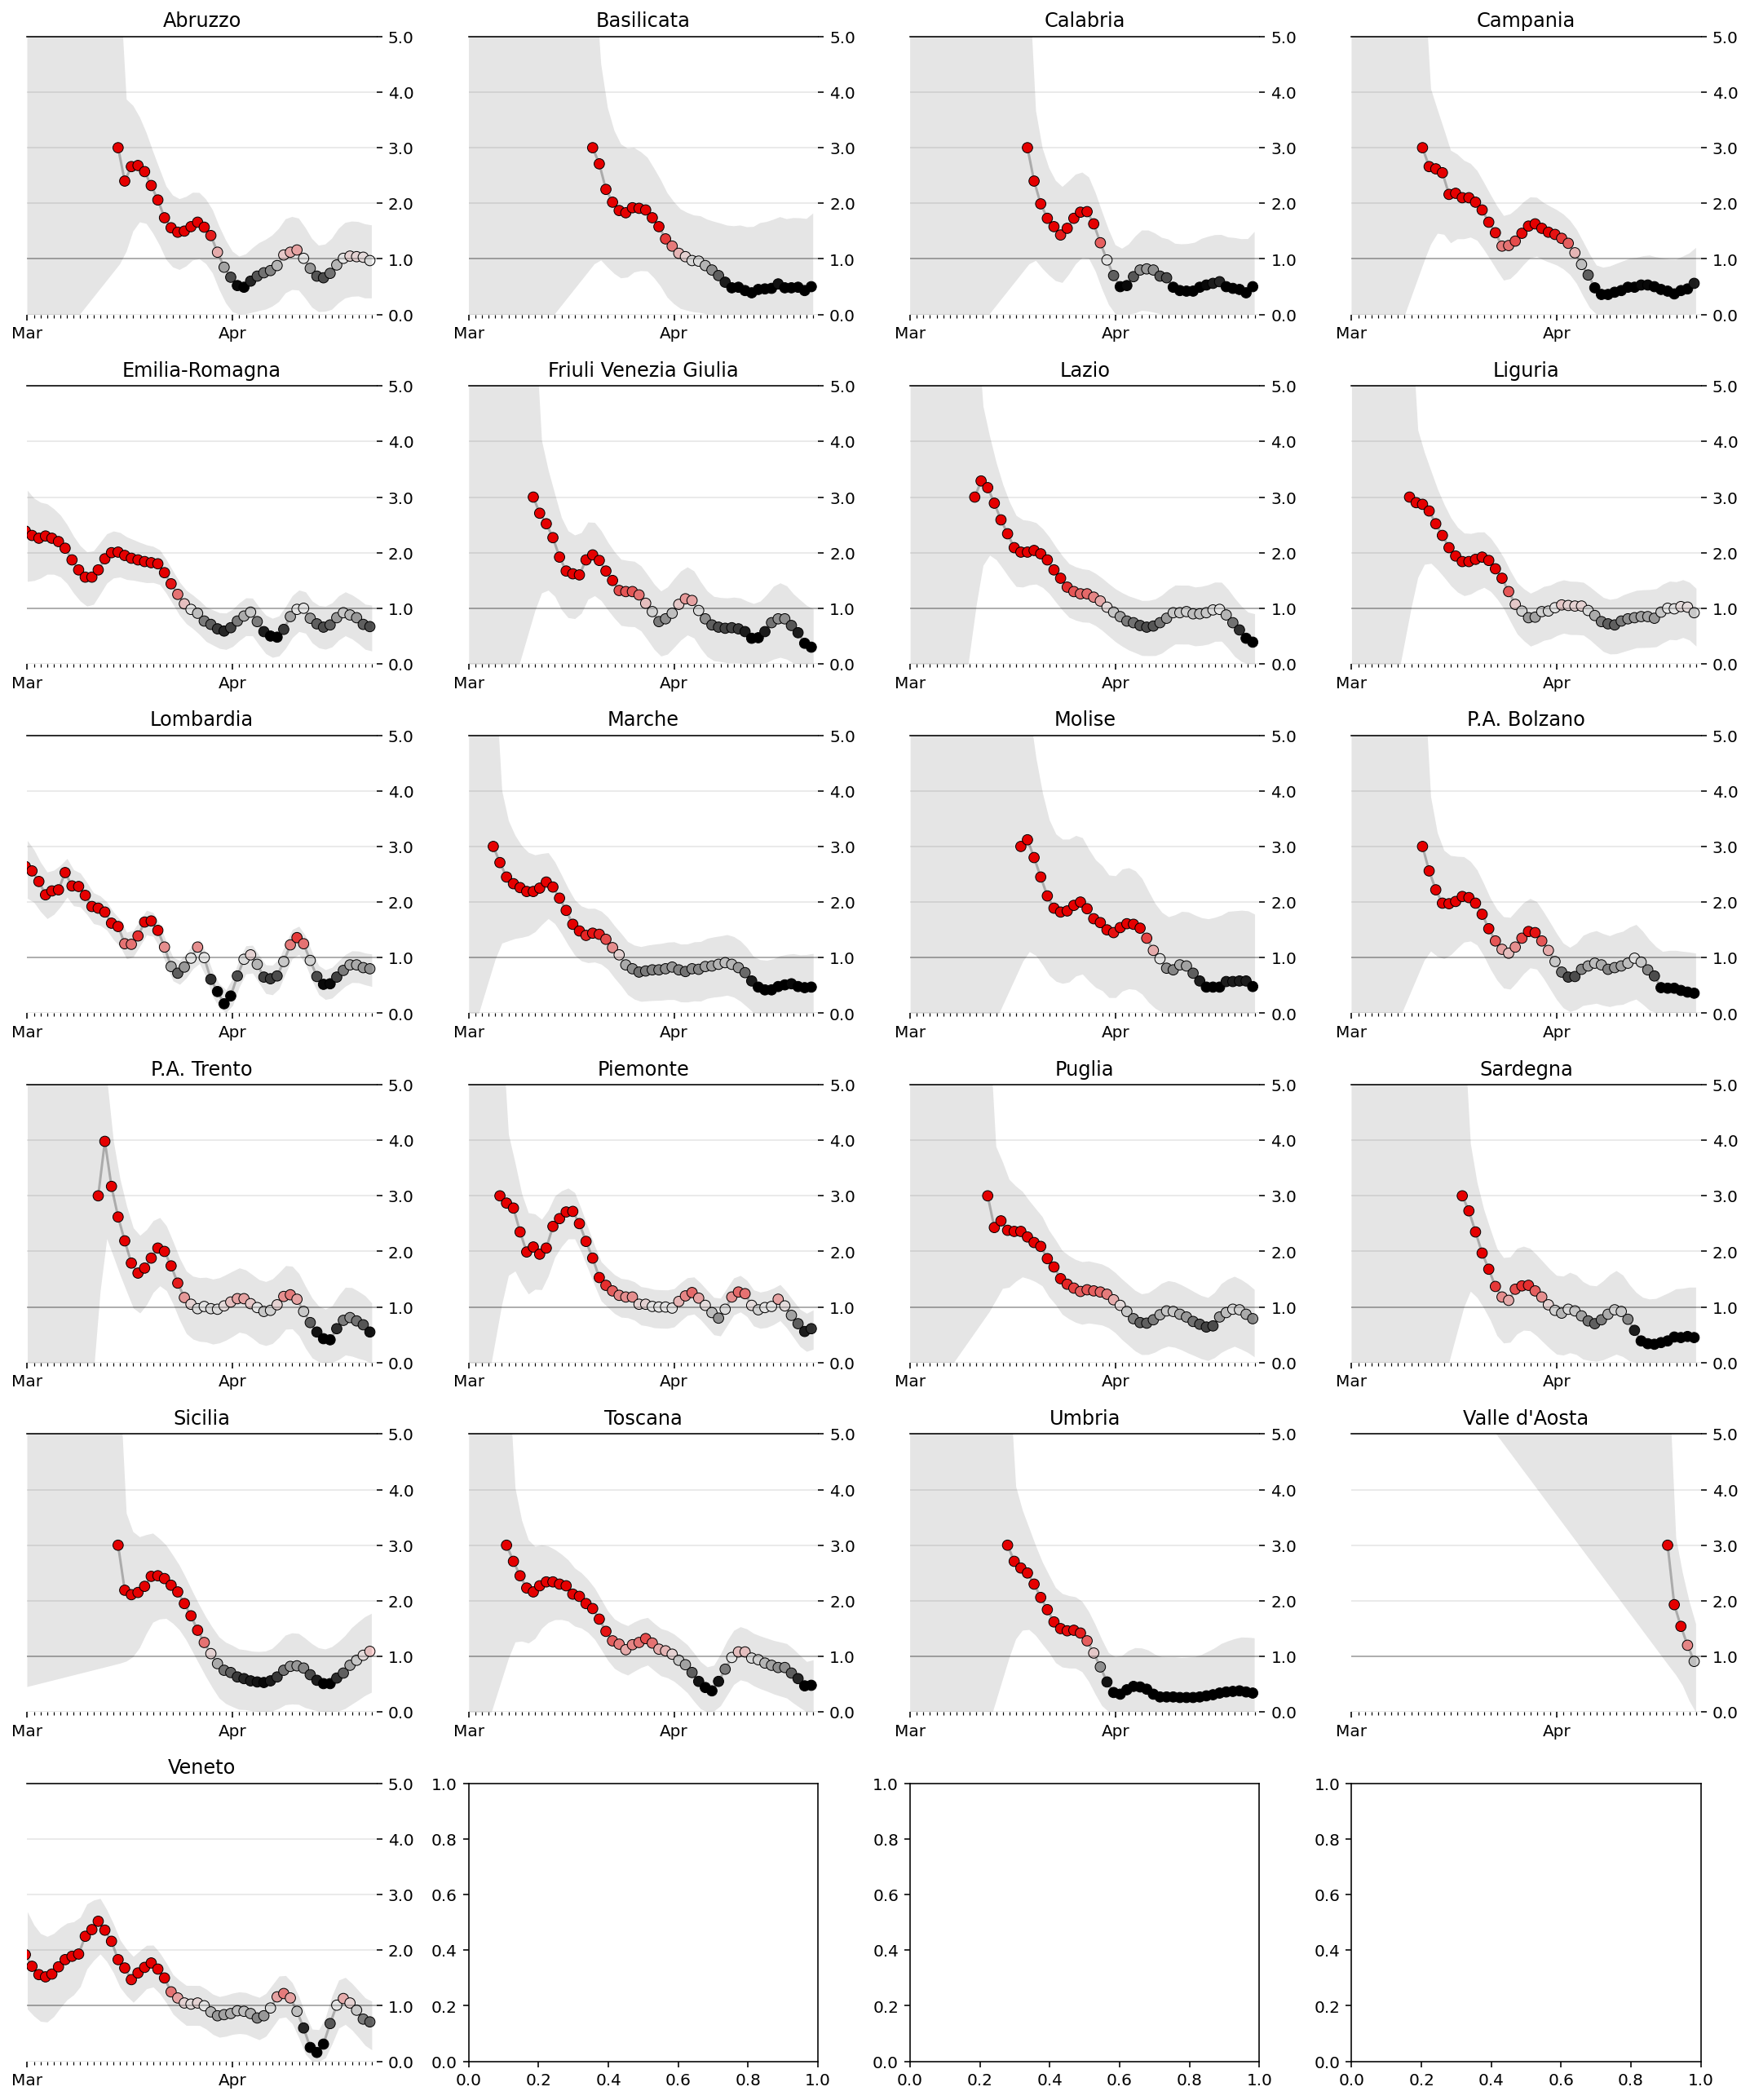

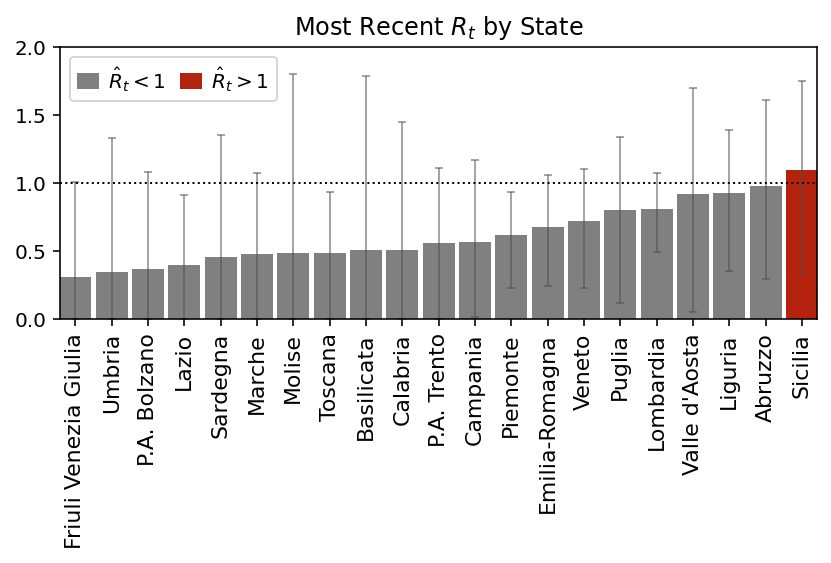

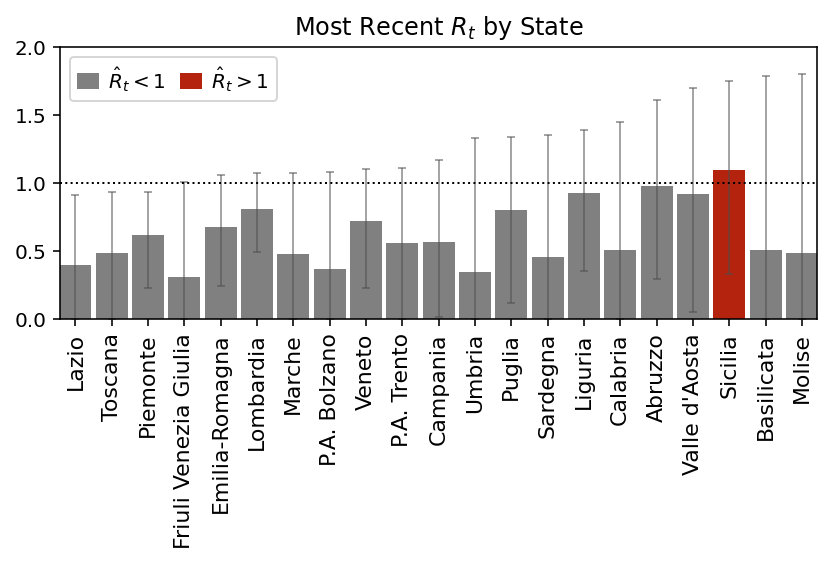

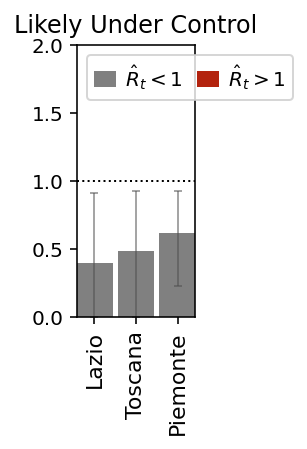

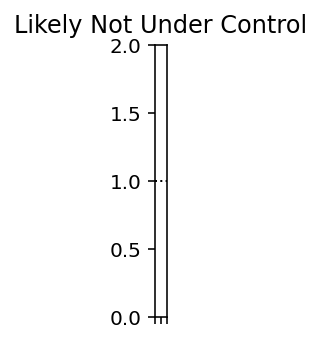

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

# Evaluating the Likelihood Function

# let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# ### Performing the Bayesian Update
# 
# To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:


posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

# Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.
# 
# From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

most_likely_values = posteriors.idxmax(axis=0)
most_likely_values


# We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:
# 
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)

# # Real-World Application to Italy Data
# 
# ### Setup
# 
# Load US state case data from the NYT archive

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     usecols=['data','denominazione_regione','totale_casi'],
                     #index_col=['data'],
                     index_col=['denominazione_regione', 'data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()


# Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.
# 
# Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

state_name = 'Marche'

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#def prepare_cases(cases):
#    new_cases = cases.diff()    
#    smoothed = new_cases.rolling(7,win_type='gaussian',min_periods=1,center=True).mean(std=2).round()
#    
#    zeros = smoothed.index[smoothed.eq(0)]
#    if len(zeros) == 0:
#        idx_start = 0
#    else:
#        last_zero = zeros.max()
#        idx_start = smoothed.index.get_loc(last_zero) + 1
#        smoothed = smoothed.iloc[idx_start:]
#        original = new_cases.loc[smoothed.index]
#        print(original)
#    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')
# path = 'smoothed_{}.png'.format(state_name)
# plt.savefig(path)


# ### Running the Algorithm

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

# ### The Result
# 

# ### Plotting in the Time Domain with Credible Intervals

# Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# path1 = 'rt_{}.png'.format(state_name)
# plt.savefig(path1)

#Choosing the optimal $\sigma$
#
#In the previous section we described choosing an optimal $\sigma$, but we just assumed a value. But now that we can evaluate each state with any sigma, we have the tools for choosing the optimal $\sigma$.
#
#Above we said we'd choose the value of $\sigma$ that maximizes the likelihood of the data $P(k)$. Since we don't want to overfit on any one state, we choose the sigma that maximizes $P(k)$ over every state. To do this, we add up all the log likelihoods per state for each value of sigma then choose the maximum.
#
#    Note: this takes a while!


sigmas = np.linspace(1/20, 1, 20)

targets = states.index.get_level_values('denominazione_regione')
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='denominazione_regione'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=5)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

# Now that we have all the log likelihoods, we can sum for each value of sigma across states, graph it, then choose the maximum.


# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]



#Compile Final Results

#Given that we've selected the optimal $\sigma$, let's grab the precalculated posterior corresponding to that value of $\sigma$ for each state. Let's also calculate the 90% and 50% highest density intervals (this takes a little while) and also the most likely value.

final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

#Plot All Italy Regions


ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('denominazione_regione')):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')


#Export Data to CSV

# Uncomment the following line if you'd like to export the data
final_results.to_csv('rt_old.csv')


FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

filtered = final_results.index.get_level_values(0)
mr = final_results.loc[filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    
    for bar, state_name in zip(bars, mr.index):
        if mr.loc[state_name,'ML'] >= 1:
            bar.set_color(NONE_COLOR)
        if mr.loc[state_name,'ML'] <= 1:
            bar.set_color(PARTIAL_COLOR)
    
    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='$\hat{R}_t < 1$', color=PARTIAL_COLOR),
                        Patch(label='$\hat{R}_t > 1$', color=NONE_COLOR)
                    ],
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);
#plt.savefig('rt_italy.png')

mr.sort_values('High_90', inplace=True)
plot_standings(mr);
#plt.savefig('rt_italy_sorted.png')


show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');
#plt.savefig('likely_under_control_italy.png')

show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()
#plt.savefig('likelynot_under_control_italy.png')

